In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import tensorflow as tf
keras = tf.keras
from scipy import stats
from sklearn.model_selection import train_test_split

pd.set_option('display.max_columns', None)
mpl.rcParams['font.size'] = 14
mpl.rcParams['legend.fontsize'] = 'small'
mpl.rcParams['figure.titlesize'] = 'large'

In [14]:
X_train = pd.read_csv('../data/train_clean.csv', index_col='Date').drop(columns='Unnamed: 0')
X_test = pd.read_csv('../data/test_clean.csv', index_col='Date').drop(columns='Unnamed: 0')

In [15]:
X_train.index = pd.to_datetime(X_train.index)
X_test.index = pd.to_datetime(X_test.index)

In [16]:
X_train.sort_index(inplace=True)
X_test.sort_index(inplace=True)

In [20]:
piv_train = X_train[['Store_Dept', 'Weekly_Sales']].pivot_table('Weekly_Sales', X_train.index,'Store_Dept')
piv_train.fillna(0, inplace=True)
piv_test = X_test[['Store_Dept', 'Weekly_Sales']].pivot_table('Weekly_Sales', X_test.index,'Store_Dept')
piv_test.fillna(0, inplace=True)


In [21]:
def windowize_data(data, n_prev, n_future):
    '''
    returns:
        x: np array with shape (n_predictions, n_prev, 1)
        y: np array with shape (n_predictions, n_future, 1)
    '''
    n_predictions = len(data) - n_prev - n_future +1
    y = data[n_prev:]
    dates = data.index[n_prev:]
#     print(dates[:5])
    # this might be too clever
    y_indices = np.arange(n_future) + np.arange(n_predictions)[:, None]
    y = y[y_indices, None]
    y_dates = dates[y_indices, None]
    x_indices = np.arange(n_prev) + np.arange(n_predictions)[:, None]
    x = data[x_indices, None]
    return x, y, y_dates

def window_multi_groups(data, n_prev, n_future):
    '''
    returns an x and y
    '''
    ncols = data.shape[1]
    n_pred = len(data) - n_prev - n_future +1
    n_total_pred = n_pred * ncols
    x = np.zeros((n_total_pred, n_prev, 1))
    y = np.zeros((n_total_pred, n_future, 1))
    y_dates = np.empty((n_total_pred, n_future, 1),dtype='datetime64[ns]')
    for i in range(ncols):
        start = i * n_pred
        stop = start + n_pred
#         print(start,stop)
        x[start:stop, :, :], y[start:stop, :, :], y_dates[start:stop, :, :] = windowize_data(data.iloc[:,i], n_prev, n_future)
#         x, y = windowize_data(data.iloc[:,i], n_prev, n_future)
    return x, y, y_dates

In [89]:
n_prev = 54
n_future = 10
# 6 into future

# X_train_window, y_train_window, y_train_dates = window_multi_groups(piv_train, n_prev, n_future)
# X_test_window, y_test_window, y_test_dates = window_multi_groups(piv_test, n_prev, n_future)

X_train_window, y_train_window, y_train_dates = windowize_data(piv_train.iloc[:,2], n_prev, n_future)
# X_test_window, y_test_window, y_test_dates = windowize_data(piv_test, n_prev, n_future)

/home/ubuntu/anaconda3/envs/tensorflow2_latest_p37/lib/python3.7/site-packages/ipykernel/__main__.py:13: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
/home/ubuntu/anaconda3/envs/tensorflow2_latest_p37/lib/python3.7/site-packages/ipykernel/__main__.py:14: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
/home/ubuntu/anaconda3/envs/tensorflow2_latest_p37/lib/python3.7/site-packages/ipykernel/__main__.py:16: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.


In [25]:
y_pred = X_test_window[:,-1]
np.mean(keras.losses.mean_squared_error(y_test_window, y_pred)) 


InvalidArgumentError: Incompatible shapes: [53360,1] vs. [53360,10,1] [Op:SquaredDifference]

In [12]:
X_train_window.shape, y_train_window.shape

((89, 54, 1), (89,))

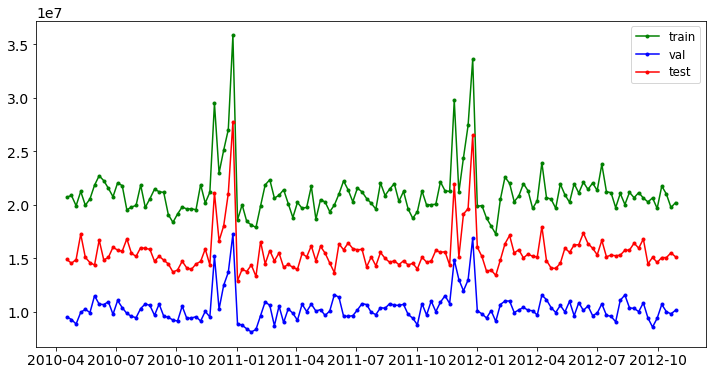

In [22]:
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(y_train_window.index, y_train_window, 'g.-', label='train')
ax.plot(y_val_window.index, y_val_window, 'b.-', label='val')
ax.plot(y_test_window.index, y_test_window, 'r.-', label='test')
ax.legend();

In [ ]:
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(y_test_window.index, y_pred, 'b.-', label='predictions', lw=0.5)
ax.plot(y_test_window.index, y_test_window, 'r.', label='actual')
ax.legend();

In [88]:
X_train_window[0], y_train_window[0]

(array([[24924.5 ],
        [46039.49],
        [41595.55],
        [19403.54],
        [21827.9 ],
        [21043.39],
        [22136.64],
        [26229.21],
        [57258.43],
        [42960.91],
        [17596.96],
        [16145.35],
        [16555.11],
        [17413.94],
        [18926.74],
        [14773.04],
        [15580.43],
        [17558.09],
        [16637.62],
        [16216.27],
        [16328.72],
        [16333.14],
        [17688.76],
        [17150.84],
        [15360.45],
        [15381.82],
        [17508.41],
        [15536.4 ],
        [15740.13],
        [15793.87],
        [16241.78],
        [18194.74],
        [19354.23],
        [18122.52],
        [20094.19],
        [23388.03],
        [26978.34],
        [25543.04],
        [38640.93],
        [34238.88],
        [19549.39],
        [19552.84],
        [18820.29],
        [22517.56],
        [31497.65],
        [44912.86],
        [55931.23],
        [19124.58],
        [15984.24],
        [17359.7 ],


In [216]:
y_train_window.shape, y_pred.shape

((80, 10, 1), (80, 10))

In [252]:

model = keras.Sequential()
model.add(keras.layers.LSTM(64, input_shape=(n_prev, 1), return_sequences=True)) # 1 is num of variables to predict on

model.add(keras.layers.LSTM(64, return_sequences=True))
# model.add(keras.layers.Dense(64, activation='relu'))
model.add(keras.layers.Dense(n_future, activation='linear'))

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.02), loss='mape')

In [208]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mape')

In [245]:
# checkpoint_cb = keras.callbacks.ModelCheckpoint("my_keras_model.h5", save_best_only=True)
model.fit(X_train_window, y_train_window.reshape(80,10), epochs=300, batch_size=1, validation_split=0.2) 



Epoch 1/300
64/64 [==============================] - 1s 15ms/step - loss: 99.6194 - val_loss: 99.2530
Epoch 2/300
64/64 [==============================] - 0s 8ms/step - loss: 98.8302 - val_loss: 98.5056
Epoch 3/300
64/64 [==============================] - 0s 8ms/step - loss: 98.0531 - val_loss: 97.7765
Epoch 4/300
64/64 [==============================] - 0s 8ms/step - loss: 97.2835 - val_loss: 97.0426
Epoch 5/300
64/64 [==============================] - 0s 8ms/step - loss: 96.4972 - val_loss: 96.2763
Epoch 6/300
64/64 [==============================] - 0s 8ms/step - loss: 95.7038 - val_loss: 95.5294
Epoch 7/300
64/64 [==============================] - 0s 8ms/step - loss: 94.9197 - val_loss: 94.7820
Epoch 8/300
64/64 [==============================] - 0s 8ms/step - loss: 94.1362 - val_loss: 94.0421
Epoch 9/300
64/64 [==============================] - 0s 8ms/step - loss: 93.3554 - val_loss: 93.3005
Epoch 10/300
64/64 [==============================] - 0s 8ms/step - loss: 92.5755 - val_lo

In [247]:
y_pred = model.predict(X_train_window)

In [253]:
model.summary()

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_37 (LSTM)               (None, 54, 64)            16896     
_________________________________________________________________
lstm_38 (LSTM)               (None, 54, 64)            33024     
_________________________________________________________________
dense_28 (Dense)             (None, 54, 10)            650       
Total params: 50,570
Trainable params: 50,570
Non-trainable params: 0
_________________________________________________________________


In [250]:
y_pred.shape

(80, 10)

In [234]:
y_train_window.shape

(80, 10, 1)

In [151]:
y_train_dates[0]

array([['2011-02-18T00:00:00.000000000'],
       ['2011-02-25T00:00:00.000000000'],
       ['2011-03-04T00:00:00.000000000'],
       ['2011-03-11T00:00:00.000000000'],
       ['2011-03-18T00:00:00.000000000'],
       ['2011-03-25T00:00:00.000000000'],
       ['2011-04-01T00:00:00.000000000'],
       ['2011-04-08T00:00:00.000000000'],
       ['2011-04-15T00:00:00.000000000'],
       ['2011-04-22T00:00:00.000000000']], dtype='datetime64[ns]')

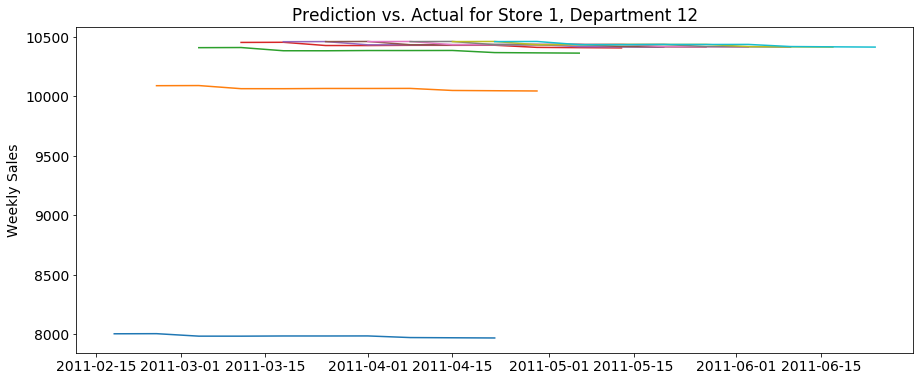

In [240]:
fig, ax = plt.subplots(figsize=(15,6))
for i in range(y_train_window.shape[0]):
# for i in range(5):
    ax.plot(y_train_dates.reshape(-1,10)[i], y_pred[i], label='predictions')
#     print(y_pred[0][i])
# ax.plot(piv_train.iloc[:,2], label='actual')
# ax.axhline(piv_train.iloc[:,2].mean())
# ax.plot(y_test_dates.reshape(-1,10)[79], y_test_window.reshape(-1,10)[79::80].sum(axis=0), label='actual')
# ax.plot(y_test_window.index, y_test_window, 'r.-', label='actual')
# ax.legend()
ax.set_title('Prediction vs. Actual for Store 1, Department 12')
ax.set_ylabel('Weekly Sales');

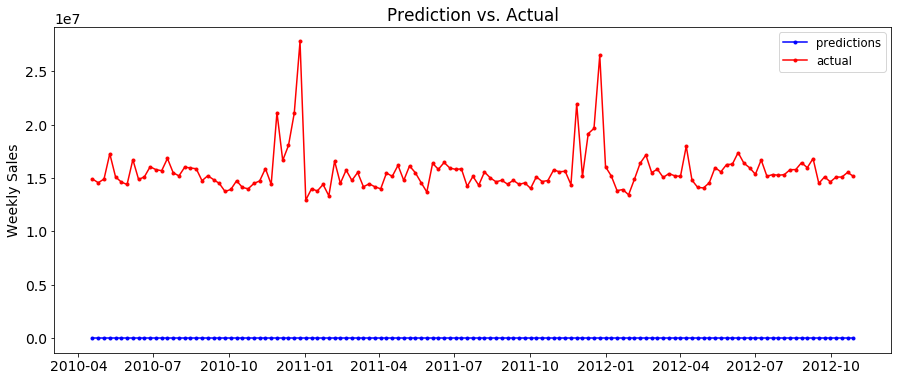

In [25]:
fig, ax = plt.subplots(figsize=(15,6))
ax.plot(y_test_window.index, y_pred, 'b.-', label='predictions')
ax.plot(y_test_window.index, y_test_window, 'r.-', label='actual')
ax.legend()
ax.set_title('Prediction vs. Actual')
ax.set_ylabel('Weekly Sales');

In [ ]:
y_pred

In [18]:
X_test_window

array([[[16949557.13000003],
        [15527423.02000002],
        [14904971.82999999],
        ...,
        [14034991.80999999],
        [16483324.48      ],
        [15761521.46999999]],

       [[15527423.02000002],
        [14904971.82999999],
        [14857999.26999999],
        ...,
        [16483324.48      ],
        [15761521.46999999],
        [14906580.86      ]],

       [[14904971.82999999],
        [14857999.26999999],
        [15453439.02999999],
        ...,
        [15761521.46999999],
        [14906580.86      ],
        [14555150.93000003]],

       ...,

       [[15310966.89999999],
        [15771052.76000002],
        [15789121.06999999],
        ...,
        [15101210.08000001],
        [14635362.29999998],
        [15089821.07      ]],

       [[15771052.76000002],
        [15789121.06999999],
        [16433747.40999999],
        ...,
        [14635362.29999998],
        [15089821.07      ],
        [15084852.99999999]],

       [[15789121.06999999],
        [1643